# Database
Database normalization is the process of structuring a relational database in accordance with a series of so-called normal forms in order to reduce data redundancy and improve data integrity.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)

## Read full dataframe from file
The data have been properly cleaned in previous steps. Each column of the dataframe is a variable and each row is an observation. All entries in this dataset are now assumed to be correct. Any columns or entries that happened to contain more than a single piece of information (in the 'location' column for example) have either been split or removed. Thus, by this time this dataframe satisfies the first normal form. However, dependency between columns still exist, and we would like to remove this dependency to minimize redundancy.

In [2]:
combined = pd.read_csv('train.csv')
combined.sample(5)

,raw_row_number,location,county_name,subject_age,subject_race,subject_sex,officer_id_hash,department_name,type,arrest_made,citation_issued,warning_issued,outcome,frisk_performed,search_conducted,search_person,search_vehicle,reason_for_stop,raw_Ethnicity,raw_Race,raw_action_description,date_time
2624797,2348408,fayetteville,cumberland county,19.0,white,male,58785d24d3,Fayetteville Police Department,vehicular,False,False,True,warning,False,False,False,False,Vehicle Regulatory Violation,N,W,Written Warning,2002-11-14 18:00:00
1227692,15681372,charlotte area,mecklenburg county,40.0,other,female,91e8928e63,Charlotte-Mecklenburg Police Department,vehicular,False,False,True,warning,False,False,False,False,Vehicle Regulatory Violation,N,I,Verbal Warning,2012-11-28 14:31:00
1764365,17279510,charlotte area,mecklenburg county,23.0,black,male,3ef5561f19,Charlotte-Mecklenburg Police Department,vehicular,False,True,False,citation,False,True,False,False,Vehicle Regulatory Violation,N,B,Citation Issued,2013-12-21 01:19:00
1823189,9901562,raleigh,wake county,45.0,hispanic,male,3465cb4a18,Raleigh Police Department,vehicular,False,False,True,warning,False,False,False,False,Vehicle Regulatory Violation,H,W,Verbal Warning,2009-05-21 07:17:00
1642874,5436666,raleigh,wake county,20.0,black,female,013d6d9689,Raleigh Police Department,vehicular,False,False,True,warning,False,False,False,False,Other Motor Vehicle Violation,N,B,Written Warning,2005-09-04 00:54:00


## Split and Remove Redundancy
There are several entities involved in a police stop: the police, the subject, the location, and the outcome of the stop. We separate these entities from the original dataframe into separated tables and create primary/foreign keys to establish relationships between tables such that the minimal amount of data is preserved to reconstruct the original dataframe, and any duplicated information is removed.

The original dataset does not contain any identification for the subjects of the stops, thus there's no built-in primary key for this table. However, for the sake of reconstructing original records, subjects can be identified as a combination of their age, race, sex, and ethnicity. This table uses an auto-generated index as its primary key. subject_id column is added to the full dataset by matching the records, which will be used as foreign key for the stop table.

In [3]:
subject=combined[["subject_age","subject_race","subject_sex","raw_Ethnicity"]].drop_duplicates()
subject.reset_index(inplace=True,drop=True)
subject.index=subject.index.rename("subject_id")
subject_id=combined.subject_age.astype('string')+combined["subject_race"]+combined["subject_sex"]+combined["raw_Ethnicity"]
strs=subject.subject_age.astype('string')+subject["subject_race"]+subject["subject_sex"]+subject["raw_Ethnicity"]
map = dict(zip(strs, subject.index.values))
id=[map[s] for s in subject_id]
combined["subject_id"]=id
subject.sample(5)

,subject_age,subject_race,subject_sex,raw_Ethnicity
subject_id,,,,
297,30.0,unknown,male,N
811,76.0,other,female,N
198,42.0,white,male,N
250,47.0,black,female,N
779,110.0,asian/pacific islander,male,N


Each location should ideally belong to one and only one county, but due to the existence of missing values, for some records we only know the county name. To solve this, a similar approach as in previous case is adapted. An auto-generated index serves as the primary key of the table, and a foreign key column is added to the full table.

In [4]:
location=combined[["location", "county_name"]].drop_duplicates().reset_index(drop=True)
location.index=location.index.rename("location_id")
strs=location["location"]+location["county_name"]
map = dict(zip(strs, location.index.values))
location_id=combined["location"]+combined["county_name"]
id=[map[s] for s in location_id]
combined["location_id"]=id
location.sample(5)

,location,county_name
location_id,,
51,fayettevilleq,cumberland county
241,sp,durham county
276,charotte,mecklenburg county
42,durham,duplin county
234,fayatteville,cumberland county


The police involved in the stops has their id in the records, which becomes the primary key of this table, and each police officer works in one and only one police department.

In [5]:
officers=combined[["officer_id_hash","department_name"]].drop_duplicates()
officers.set_index("officer_id_hash",inplace=True)
officers.sample(5)

,department_name
officer_id_hash,
59f939906e,Winston-Salem Police Department
e8da237eff,Fayetteville Police Department
f10436613c,Greensboro Police Department
8868b8acc4,Charlotte-Mecklenburg Police Department
7a1a7aa0ff,Fayetteville Police Department


The stops table stores the stop records, including the time, reason, and outcome of the stops. It also contains subject_id, location_id, and officer_id as foreign keys which relate it to the other three tables.

In [6]:
stops=combined[["raw_row_number","date_time", "reason_for_stop","raw_action_description","officer_id_hash","location_id","subject_id"]]
stops.set_index("raw_row_number",inplace=True)
stops.sample(5)

,date_time,reason_for_stop,raw_action_description,officer_id_hash,location_id,subject_id
raw_row_number,,,,,,
19077858,2015-01-04 00:15:00,Other Motor Vehicle Violation,Verbal Warning,f835b4f49b,3,88
4109041,2004-03-08 02:29:00,Investigation,Citation Issued,ac9d1603cb,3,109
15505805,2012-10-25 21:41:00,Investigation,Verbal Warning,e805444257,6,31
12831256,2011-01-23 14:34:36,Stop Light/Sign Violation,Verbal Warning,a75ed3a497,259,295
3187033,2003-08-14 00:08:00,Vehicle Equipment Violation,Citation Issued,c089bfecc7,8,60


Now the entity relationship diagram of the dataset is depicted in the following graph. The columns in each table now depends only on the primary key, and any redundant rows have been removed.

<!-- ![er diagram](data/er-diagram.png) -->

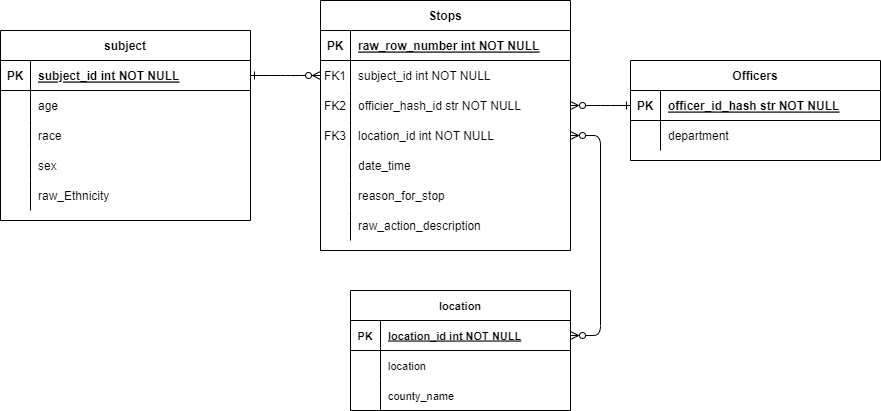

In [7]:
from IPython.display import Image
Image(filename='data/er-diagram.png')

## Create Database
We first create a database engine and then connect to the database engine and create the relational table.

In [8]:
from sqlalchemy import create_engine
from pandas import read_sql_query
engine = create_engine('sqlite:///:memory:')

subject.to_sql('subject', engine)
stops.to_sql('stops', engine)
officers.to_sql('officiers', engine)
location.to_sql('location', engine)

283

Then we can execute and capture the results from various SQL queries.

In this example, we selected all subjects who are older than 50.

In [9]:
read_sql_query('SELECT * FROM subject WHERE subject_age>50.0', engine)

,subject_id,subject_age,subject_race,subject_sex,raw_Ethnicity
0,2,64.0,white,female,N
1,5,52.0,white,male,N
2,12,56.0,white,female,N
3,38,59.0,white,male,N
4,39,58.0,black,male,N
...,...,...,...,...,...
515,997,76.0,unknown,female,N
516,998,99.0,white,female,N
517,999,97.0,hispanic,male,H
518,1000,83.0,other,male,N


In this example, we selected all stop records that involved subjects who are not white.

In [10]:
read_sql_query('SELECT date_time, reason_for_stop, raw_action_description FROM stops JOIN subject ON stops.subject_id=subject.subject_id WHERE subject_race!="white"', engine)

,date_time,reason_for_stop,raw_action_description
0,2014-03-12 00:21:00,Vehicle Equipment Violation,Citation Issued
1,2014-12-25 00:08:00,Driving While Impaired,On-View Arrest
2,2008-07-09 14:30:00,Speed Limit Violation,Citation Issued
3,2008-07-22 12:06:29,Investigation,Citation Issued
4,2015-07-08 08:14:00,Vehicle Regulatory Violation,Citation Issued
...,...,...,...
2120528,2014-11-24 10:28:00,Vehicle Equipment Violation,Citation Issued
2120529,2015-01-22 15:22:00,Vehicle Regulatory Violation,Verbal Warning
2120530,2005-08-04 13:23:00,Investigation,No Action Taken
2120531,2000-05-21 02:32:00,Vehicle Regulatory Violation,Citation Issued
